# ECE 228 Unet (mitochondria dataset)

# Python Imports

In [1]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
%matplotlib inline  

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms, utils
from skimage import io, transform
from skimage.color import rgb2gray

from models import * 



# Load Mitochondria Data

Train imgs shape =  (20, 1024, 1024)
Validation imgs shape =  (10, 1024, 1024)
Test imgs shape =  (5, 1024, 1024)


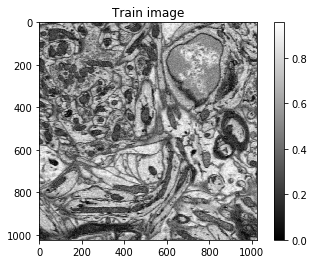

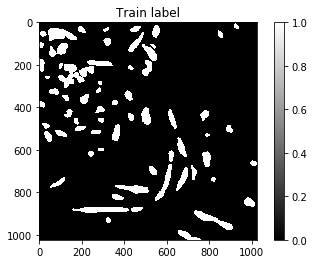

In [2]:
mito_dir = './datasets/mitochondria/'

def import_mito(mito_dir): 
    
    mito_train_img_dir = mito_dir+'training/images/'
    mito_train_lbl_dir = mito_dir+'training/labels/'   
    mito_val_img_dir = mito_dir+'validation/images/'
    mito_val_lbl_dir = mito_dir+'validation/labels/'
    mito_test_img_dir = mito_dir+'testset/'

    # load train imgs and labels 
    mito_train_imgs = import_dir(mito_train_img_dir)
    mito_train_lbls = import_dir(mito_train_lbl_dir)
   
    # convert train labels to binary mask
    mito_train_lbls_gray = []
    for img in mito_train_lbls:
        mito_train_lbls_gray.append(rgb2gray(img))
    mito_train_lbls = np.array(mito_train_lbls_gray)
    mito_train_lbls[mito_train_lbls!=0]=1
    
    # load validation imgs and labels 
    mito_val_imgs = import_dir(mito_val_img_dir)
    mito_val_lbls = import_dir(mito_val_lbl_dir)
    
    # convert validation labels to binary masks 
    mito_val_lbls_gray = []
    for img in mito_val_lbls:
        mito_val_lbls_gray.append(rgb2gray(img))
    mito_val_lbls = np.array(mito_val_lbls_gray)
    mito_val_lbls[mito_val_lbls!=0]=1
    
    # load test imgs 
    mito_test_imgs = import_dir(mito_test_img_dir)
    
    
    return mito_train_imgs, mito_train_lbls, mito_val_imgs, mito_val_lbls, mito_test_imgs

def import_dir(dirn): 
    
    files = [f for f in os.listdir(dirn) if os.path.isfile(os.path.join(dirn, f))]
    files.sort()
    
    imgs = []
    for f in files: 
        imgs.append(plt.imread(dirn+f))
    return np.array(imgs)
    


mito_train_imgs, mito_train_lbls, mito_val_imgs, mito_val_lbls, mito_test_imgs = import_mito(mito_dir)


print("Train imgs shape = ",mito_train_imgs.shape)
print("Validation imgs shape = ",mito_val_imgs.shape)
print("Test imgs shape = ",mito_test_imgs.shape)

plt.imshow(mito_train_imgs[0], cmap="gray")
plt.title("Train image")
plt.colorbar()
plt.show()

plt.imshow(mito_train_lbls[0], cmap="gray")
plt.title("Train label")
plt.colorbar()
plt.show()

# Training methods

In [3]:
# Prep GPU
GPU = torch.cuda.is_available()
print("GPU is {}enabled ".format(['not ', ''][GPU]))

new_size = 1024
def training(model, inputs, targets,val,val_target, epochs):
    # set training mode
    model.train()
    
    for epoch in range(epochs): 
        
        num_batches = 0
        avg_loss = 0
        
        # gradient descent TODO: switch to mini batch SGD 
        for (img,lbl) in zip(inputs, targets): 
            
            # resize and expand imgs according to pytorch convention (N, channels, height, width)
            img = transform.resize(img, (new_size, new_size))
            img = np.expand_dims(img, axis=0)
            img = np.expand_dims(img, axis=0) 

            lbl = transform.resize(lbl, (new_size, new_size))
            lbl = np.expand_dims(lbl, axis=0)
            lbl = np.expand_dims(lbl, axis=0)
            
            
            # create pytorch cuda variables 
            x = Variable(torch.FloatTensor(img))
            target = Variable(torch.FloatTensor(lbl))
            
            if GPU: 
                x = x.cuda()
                target = target.cuda()

                
            # get output and loss
            output = model(x)
            loss = criterion(output, target)
            
            # backpropagate 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            avg_loss += loss.data[0]
            #print("loss = ",loss.data[0])
            
            num_batches += 1
  

        avg_loss /= num_batches
        print('epoch: ' + str(epoch) + ', train loss: ' + str(avg_loss))
        
        
        

        # do one random prediction 
        i = np.random.randint(0,val.shape[0])
        val_img = transform.resize(val[i], (new_size,new_size))
        val_img = np.expand_dims(val_img, axis=0)
        val_img = np.expand_dims(val_img, axis=0)
        val_img = Variable(torch.FloatTensor(val_img))
        if GPU: 
            val_img = val_img.cuda()
        prediction = model(val_img)
        prediction = prediction.data.cpu().numpy()
        prediction = prediction.squeeze()
        

        
        # plot prediction and real label 
        f, (ax1,ax2) = plt.subplots(1,2, sharey=True,figsize=(15,15), dpi=80)
        ax1.imshow(prediction, cmap="gray")
        ax1.set_title("Prediction")
        ax2.imshow(val_target[i], cmap="gray")
        ax2.set_title("Real label")
        plt.show()
        
        


GPU is enabled 


# Run Training 

/datasets/home/89/189/ltindall/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


epoch: 0, train loss: 0.3513263285160065


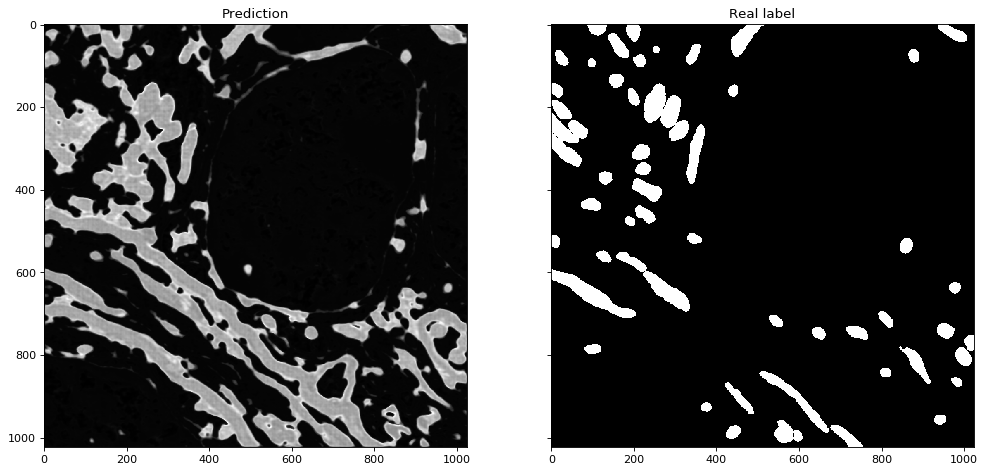

epoch: 1, train loss: 0.17655225172638894


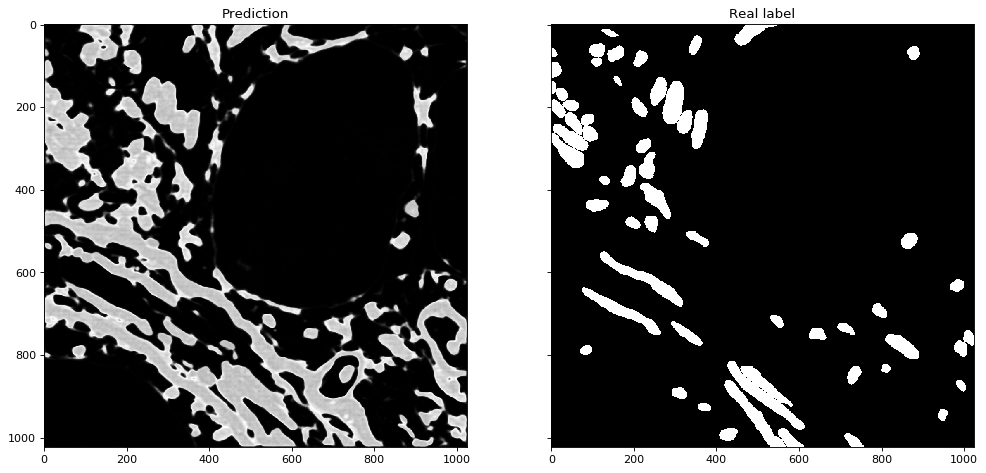

epoch: 2, train loss: 0.17027790620923042


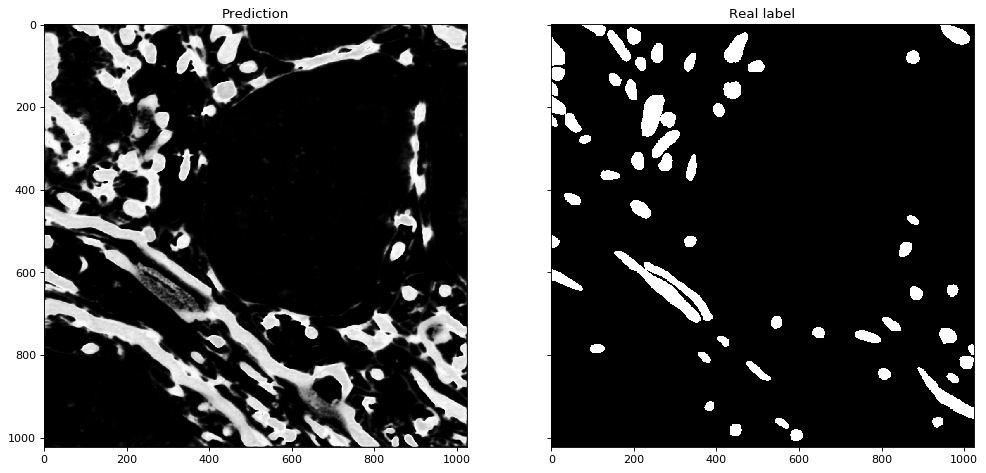

epoch: 3, train loss: 0.155708896368742


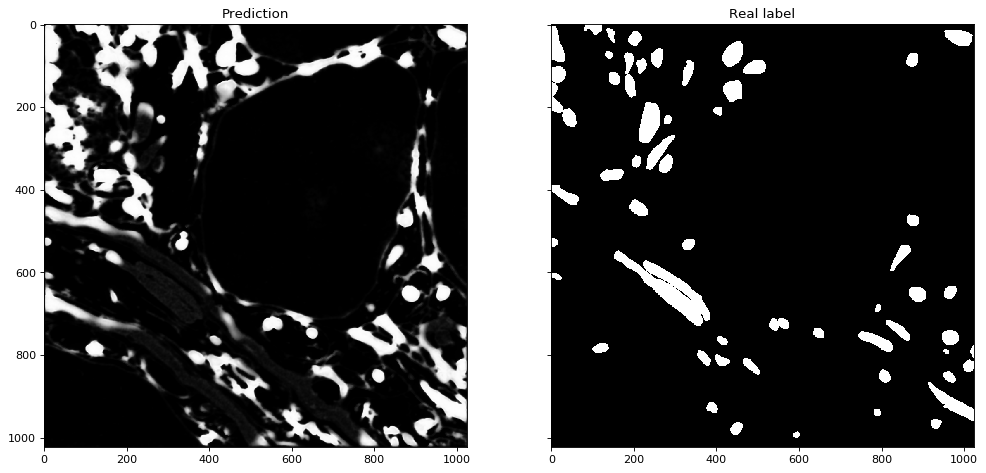

epoch: 4, train loss: 0.14445710927248


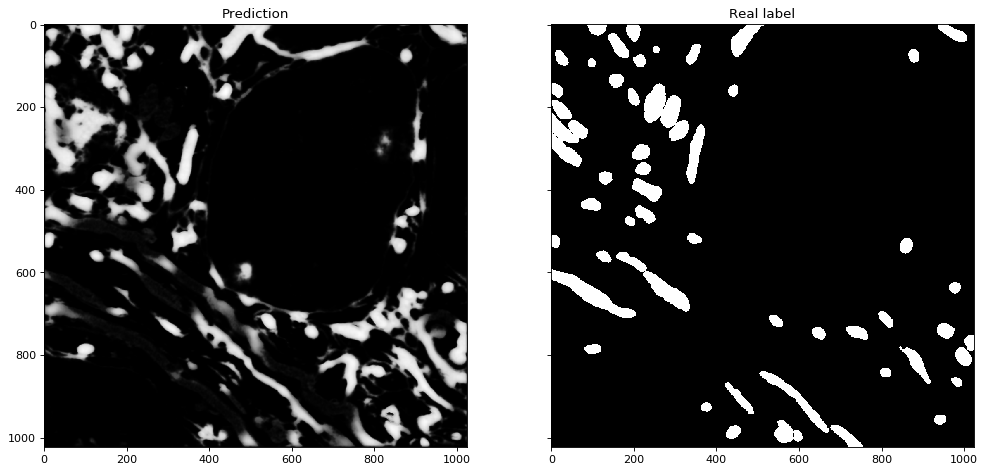

KeyboardInterrupt: 

In [4]:

# unet(n_channels, n_classes, n_filters_start=64 )
un = unet(1,1)

if GPU: 
    un = un.cuda()

optimizer = torch.optim.Adam(un.parameters(), lr=0.01)
criterion = nn.BCELoss()

# training(model, inputs, targets,val,val_target, epochs)
training(un,mito_train_imgs, mito_train_lbls, mito_val_imgs, mito_val_lbls, 1000)

In [ ]:
whos

# todo


1. accuracy

2. batches

3. disconnecting objects
